## Data Preprocessing

In [463]:
import pandas as pd
import numpy as np

Kaggle Dataset split into train and test
- Training set: twitter_train.csv
- Test set: twitter_test.csv

In [493]:
df = pd.read_csv('./data/twitter_train.csv')

In [494]:
df.head(3)

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative


In [495]:
df.shape

(27481, 4)

Removal of null values

In [496]:
df[df.isnull().any(axis=1)]

,textID,text,selected_text,sentiment
314,fdb77c3752,NaN,NaN,neutral


In [497]:
df = df.dropna(subset=['text'])

In [498]:
# Drop the only NaN row
df.shape

(27480, 4)

In [499]:
#Check if all rows are non-null
len(df[df.isnull().any(axis=1)]) == 0

True

Encoding of sentiment values into integers

In [500]:
df['sentiment'].value_counts()

neutral     11117
positive     8582
negative     7781
Name: sentiment, dtype: int64

In [501]:
# Encode snetiment with numerics
def encode_sentiment(x):
  if x == 'positive':
    return 1
  elif x == 'negative':
    return -1
  else:
    return 0

In [502]:
df['sentiment'] = df['sentiment'].apply(encode_sentiment)

In [503]:
df.head(3)

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",0
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,-1
2,088c60f138,my boss is bullying me...,bullying me,-1


Preparing training and test datasets

In [504]:
#Rebalancing training dataset

obs_num = min(df['sentiment'].value_counts())

df_class_positive = df[df['sentiment'] == 1]
df_class_neutral = df[df['sentiment'] == 0]
df_class_negative = df[df['sentiment'] == -1]

sample_positive = df_class_positive.sample(obs_num)
sample_neutral = df_class_neutral.sample(obs_num)
sample_negative = df_class_negative.sample(obs_num)

#Concat and shuffle
df_new = pd.concat([sample_positive, sample_neutral, sample_negative], axis=0).sample(frac=1)

In [505]:
df_new.sentiment.value_counts()

-1    7781
 1    7781
 0    7781
Name: sentiment, dtype: int64

In [506]:
df_test = pd.read_csv('./data/twitter_test.csv')

In [507]:
df_test['sentiment'] = df_test['sentiment'].apply(encode_sentiment)

In [508]:
X_train = df_new.text
y_train = df_new.sentiment
X_test = df_test.text
y_test = df_test.sentiment

In [509]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(23343,)
(3534,)
(23343,)
(3534,)


Set up tweet dataset to be labelled

In [568]:
tweets = pd.read_csv('./data/tweets.csv')
tweets.head(3)

,Unnamed: 0,url,date,content,id,user,outlinks,tcooutlinks,replyCount,retweetCount,...,conversationId,lang,source,sourceUrl,sourceLabel,media,retweetedTweet,quotedTweet,mentionedUsers,device
0,0,https://twitter.com/lundp/status/1547135712536...,2012-01-04 23:59:24+00:00,Trying new iSkin protector on MacBook Pro. And...,154713571253686272,https://twitter.com/lundp,[],[],0,0,...,154713571253686272,en,"<a href=""http://itunes.apple.com/us/app/twitte...",http://itunes.apple.com/us/app/twitter/id40978...,Twitter for Mac,NaN,NaN,NaN,NaN,mac
1,1,https://twitter.com/JayDCooke/status/154713564...,2012-01-04 23:59:22+00:00,I'm ready to get on the #MacBook,154713564031090689,https://twitter.com/JayDCooke,[],[],0,0,...,154713564031090689,en,"<a href=""http://twitter.com/download/iphone"" r...",http://twitter.com/download/iphone,Twitter for iPhone,NaN,NaN,NaN,NaN,mac
2,2,https://twitter.com/Semhar/status/154713498935...,2012-01-04 23:59:07+00:00,Syncing my entire life. All my personal & DAWN...,154713498935496704,https://twitter.com/Semhar,[],[],0,0,...,154713498935496704,en,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",http://twitter.com,Twitter Web Client,NaN,NaN,NaN,NaN,mac


In [569]:
tweets.shape

(61440, 22)

# Approach 1: CountVectorizer/TFIDFVectorizer with lemmatization

Create custom tokenizer to enable lemmatization using spaCy

In [510]:
# Initialise spacy 
import string
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

# Get nltk set of english words
import nltk
nltk.download('words')

[nltk_data] Downloading package words to /Users/bryankoh/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [511]:
# Create our list of punctuation marks
punctuations = string.punctuation

# Create our list of stopwords
nlp = spacy.load("en_core_web_sm")
stop_words = spacy.lang.en.stop_words.STOP_WORDS

# Set nltk vocab
vocab = set(nltk.corpus.words.words())

# Creating our tokenizer function
def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = nlp(sentence)

    # Lemmatizing each token
    mytokens = [ token.lemma_ for token in mytokens if token.lemma_ in vocab]

    # Removing stop words
    mytokens = [ token for token in mytokens if token not in stop_words ]

    # return preprocessed list of tokens
    return mytokens

Helper functions to test various machine learning models

In [572]:
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB  
from sklearn.linear_model import LogisticRegression

#Insert document-term matrices, y-values and model
def test_nb_model(X_train_dtm, y_train, X_test_dtm, y_test, return_model = False):
    nb = MultinomialNB()
    nb.fit(X_train_dtm, y_train)
    y_pred = nb.predict(X_test_dtm)
    train_acc = metrics.accuracy_score(y_train, nb.predict(X_train_dtm))
    test_acc = metrics.accuracy_score(y_test, y_pred)
    if return_model:
      return train_acc, test_acc, nb
    else:
      return train_acc, test_acc

def test_lr_model(X_train_dtm, y_train, X_test_dtm, y_test, return_model = False):
    lr = LogisticRegression(random_state = 0)
    lr.fit(X_train_dtm, y_train)
    y_pred = lr.predict(X_test_dtm)
    train_acc = metrics.accuracy_score(y_train, lr.predict(X_train_dtm))
    test_acc = metrics.accuracy_score(y_test, y_pred)
    if return_model:
      return train_acc, test_acc, lr
    else:
      return train_acc, test_acc


## CountVectorizer



In [556]:
# Iterate through max_df = 0.6, 0.8, 1.0
# Iterate through max_features = 500, 750, 1000, nan

arrays = [
    np.array([0.6, 0.6, 0.6, 0.6, 0.8, 0.8, 0.8, 0.8, 1.0, 1.0, 1.0, 1.0]),
    np.array(['default', '500', '750', '1000', 'default', '500', '750', '1000', 'default', '500', '750', '1000'])]

#Naive Bayes results DF
nb_results = pd.DataFrame(np.zeros((12, 2)), index=arrays)
nb_results.rename(columns={0: "training", 1: "test"}, inplace=True)

#Logisitic regression results DF
lr_results = pd.DataFrame(np.zeros((12, 2)), index=arrays)
lr_results.rename(columns={0: "training", 1: "test"}, inplace=True)

In [559]:
max_df = [0.6, 0.8, 1.0]
max_features = ['default', '500', '750', '1000']

from sklearn.feature_extraction.text import CountVectorizer
def search_cv_best_params():
  iteration = 1
  for i in max_df:
    for j in max_features:
        #print("Iteration " + str(iteration))
        #print("max_df: " + str(i))
        #print("max_features: " + str(j))
        if j == 'default':
          cv = CountVectorizer(tokenizer = spacy_tokenizer, max_df = i)
        else:
          cv = CountVectorizer(tokenizer = spacy_tokenizer, max_df = i, max_features = int(j))

        train_dtm = cv.fit_transform(X_train)
        X_train_dtm = pd.DataFrame(train_dtm.toarray(), columns=cv.get_feature_names())

        test_dtm = cv.transform(X_test)
        X_test_dtm = pd.DataFrame(test_dtm.toarray(), columns=cv.get_feature_names())

        nb_train, nb_test = test_nb_model(X_train_dtm, y_train, X_test_dtm, y_test)
        lr_train, lr_test = test_lr_model(X_train_dtm, y_train, X_test_dtm, y_test)
        
        nb_results.loc[i, j]['training'] = nb_train
        nb_results.loc[i, j]['test'] = nb_test

        lr_results.loc[i, j]['training'] = lr_train
        lr_results.loc[i, j]['test'] = lr_test

        iteration += 1

search_cv_best_params()

In [561]:
nb_results

training      test
0.6 default  0.741293  0.621958
    500      0.640963  0.607527
    750      0.655014  0.619411
    1000     0.666067  0.623373
0.8 default  0.741293  0.621958
    500      0.640963  0.607527
    750      0.655014  0.619411
    1000     0.666067  0.623373
1.0 default  0.741293  0.621958
    500      0.640963  0.607527
    750      0.655014  0.619411
    1000     0.666067  0.623373

In [571]:
lr_results

training      test
0.6 default  0.810393  0.693265
    500      0.693698  0.681381
    750      0.711520  0.689021
    1000     0.723215  0.690436
0.8 default  0.810393  0.693265
    500      0.693698  0.681381
    750      0.711520  0.689021
    1000     0.723215  0.690436
1.0 default  0.810393  0.693265
    500      0.693698  0.681381
    750      0.711520  0.689021
    1000     0.723215  0.690436

## TFIDFVectorizer

In [563]:
#Naive Bayes results DF
nb_tfidf_results = pd.DataFrame(np.zeros((12, 2)), index=arrays)
nb_tfidf_results.rename(columns={0: "training", 1: "test"}, inplace=True)

#Logisitic regression results DF
lr_tfidf_results = pd.DataFrame(np.zeros((12, 2)), index=arrays)
lr_tfidf_results.rename(columns={0: "training", 1: "test"}, inplace=True)

In [564]:
from sklearn.feature_extraction.text import TfidfVectorizer
max_df = [0.6, 0.8, 1.0]
max_features = ['default', '500', '750', '1000']

from sklearn.feature_extraction.text import CountVectorizer
def search_tfidf_best_params():
  iteration = 1
  for i in max_df:
    for j in max_features:
        #print("Iteration " + str(iteration))
        #print("max_df: " + str(i))
        #print("max_features: " + str(j))
        if j == 'default':
          cv = TfidfVectorizer(tokenizer = spacy_tokenizer, max_df = i)
        else:
          cv = TfidfVectorizer(tokenizer = spacy_tokenizer, max_df = i, max_features = int(j))

        train_dtm = cv.fit_transform(X_train)
        X_train_dtm = pd.DataFrame(train_dtm.toarray(), columns=cv.get_feature_names())

        test_dtm = cv.transform(X_test)
        X_test_dtm = pd.DataFrame(test_dtm.toarray(), columns=cv.get_feature_names())

        nb_train, nb_test = test_nb_model(X_train_dtm, y_train, X_test_dtm, y_test)
        lr_train, lr_test = test_lr_model(X_train_dtm, y_train, X_test_dtm, y_test)

        nb_tfidf_results.loc[i, j]['training'] = nb_train
        nb_tfidf_results.loc[i, j]['test'] = nb_test
        lr_tfidf_results.loc[i, j]['training'] = lr_train
        lr_tfidf_results.loc[i, j]['test'] = lr_test

        iteration += 1
        
search_tfidf_best_params()

In [566]:
nb_tfidf_results

training      test
0.6 default  0.750032  0.627051
    500      0.640620  0.616016
    750      0.656300  0.622807
    1000     0.665510  0.630447
0.8 default  0.750032  0.627051
    500      0.640620  0.616016
    750      0.656300  0.622807
    1000     0.665510  0.630447
1.0 default  0.750032  0.627051
    500      0.640620  0.616016
    750      0.656300  0.622807
    1000     0.665510  0.630447

In [570]:
lr_tfidf_results

training      test
0.6 default  0.778220  0.696095
    500      0.690657  0.679966
    750      0.707578  0.688738
    1000     0.718245  0.692134
0.8 default  0.778220  0.696095
    500      0.690657  0.679966
    750      0.707578  0.688738
    1000     0.718245  0.692134
1.0 default  0.778220  0.696095
    500      0.690657  0.679966
    750      0.707578  0.688738
    1000     0.718245  0.692134

It appears that models perform better when assessed on a logistic regression model model and having no limits on max_features result in the best training and test accuracy. 

Considering training and test accuracy scores, we will opt for the CountVectorizer parameters **max_df = 0.6** and the rest as default

## Labelling data using CountVectorizer(tokenizer = spacy_tokenizer, max_df = 0.6) and Naive Bayes

In [573]:
# Set up CountVectorizer
cv = CountVectorizer(tokenizer = spacy_tokenizer, max_df = 0.6)

train_dtm = cv.fit_transform(X_train)
X_train_dtm = pd.DataFrame(train_dtm.toarray(), columns=cv.get_feature_names())

test_dtm = cv.transform(X_test)
X_test_dtm = pd.DataFrame(test_dtm.toarray(), columns=cv.get_feature_names())

# Train and return logistic regression model 
lr_train, lr_test, lr = test_lr_model(X_train_dtm, y_train, X_test_dtm, y_test, return_model=True)

# Use CountVectorizer to vectorize text in tweets
tweets_copy = deepcopy(tweets)
X_tweets_dtm = cv.transform(tweets_copy.content)
X_tweets_dtm = pd.DataFrame(X_tweets_dtm.toarray(), columns=cv.get_feature_names())

# Use logistic regression model to predict sentiment
tweets_pred = lr.predict(X_tweets_dtm)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [39]:
tweets_copy['sentiment'] = tweets_pred

In [41]:
tweets_copy.to_csv('./data/tweets_cv.csv', index=False)

# Approach 2: roBERTa

In [172]:
from simpletransformers.classification import ClassificationModel
# Create a ClassificationModel
model = ClassificationModel('roberta', 'roberta-base', num_labels=3, use_cuda=False)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out

In [406]:
# Setting up a custom helper function to remove hashes, mentions and links

import re
def remove_hashtag_mentions_links(x):
    #Remove mentions
    text = re.sub("(@[A-Za-z0–9]+)","",x)
    #Remove links
    text = re.sub(r"http\S+", "", text)
    #Remove hashtags
    text = text.replace("#", "")
    return text

In [582]:
bert_train = deepcopy(df_new)
bert_train['text'] = bert_train['text'].apply(remove_hashtag_mentions_links)

In [583]:
bert_test = deepcopy(df_test)
bert_test['text'] = bert_test['text'].apply(remove_hashtag_mentions_links)

In [584]:
bert_train = bert_train[['text', 'sentiment']]
bert_test = bert_test[['text', 'sentiment']]

In [585]:
bert_train.sentiment.value_counts()

-1    7781
 1    7781
 0    7781
Name: sentiment, dtype: int64

In [586]:
bert_test.sentiment.value_counts()

 0    1430
 1    1103
-1    1001
Name: sentiment, dtype: int64

In [80]:
# roBERTa model target values must be > 0
bert_train['sentiment'] = bert_train['sentiment'].map({-1: 0, 0: 1, 1: 2})
bert_test['sentiment'] = bert_test['sentiment'].map({-1: 0, 0: 1, 1: 2})

### NOTE: Further training of roBERTa model and unsupervised labelling of dataset takes around 24 hours to run

In [200]:
model.train_model(bert_train, output_dir='./data/bert_output')

/opt/anaconda3/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


(3435, 0.640229480937557)

In [201]:
training_result, training_model_outputs, training_wrong_predictions = model.eval_model(bert_train, acc=sklearn.metrics.accuracy_score)
test_result, test_model_outputs, test_wrong_predictions = model.eval_model(bert_test, acc=sklearn.metrics.accuracy_score)


/opt/anaconda3/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:1026: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


In [202]:
#Training and test accuracies
print("Training accuracy: " + str(training_result['acc']))
print("Test accuracy: " + str(test_result['acc']))

Training accuracy: 0.8343522561863174
Test accuracy: 0.8022071307300509


In [222]:
tweets_copy = deepcopy(tweets)
tweets_copy['cleaned_content'] = tweets_copy.content.apply(remove_hashtag_mentions_links)

In [83]:
tweets_list = tweets_copy.cleaned_content.tolist()

In [205]:
bert_predictions, _ = model.predict(tweets_list)

In [207]:
tweets_copy['sentiment'] = bert_predictions

In [213]:
# Map back to -1, 0 and 1
tweets_copy['sentiment'] = tweets_copy['sentiment'].map({0: -1, 1: 0, 2: 1})

In [214]:
# Drop cleaned content and output
output = tweets_copy.drop(['cleaned_content'], axis=1)
output.to_csv('./data/tweets_bert.csv', index=False)

## Using SHAP for explainability of roBERTa model

In [121]:
import transformers
import shap
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification

### Load data labelled by roBERTa

In [226]:
output.head(2)

,Unnamed: 0,url,date,content,id,user,outlinks,tcooutlinks,replyCount,retweetCount,...,lang,source,sourceUrl,sourceLabel,media,retweetedTweet,quotedTweet,mentionedUsers,device,sentiment
0,0,https://twitter.com/lundp/status/1547135712536...,2012-01-04 23:59:24+00:00,Trying new iSkin protector on MacBook Pro. And...,154713571253686272,https://twitter.com/lundp,[],[],0.0,0.0,...,en,"<a href=""http://itunes.apple.com/us/app/twitte...",http://itunes.apple.com/us/app/twitter/id40978...,Twitter for Mac,NaN,NaN,NaN,NaN,mac,-1.0
1,1,https://twitter.com/JayDCooke/status/154713564...,2012-01-04 23:59:22+00:00,I'm ready to get on the #MacBook,154713564031090689,https://twitter.com/JayDCooke,[],[],0.0,0.0,...,en,"<a href=""http://twitter.com/download/iphone"" r...",http://twitter.com/download/iphone,Twitter for iPhone,NaN,NaN,NaN,NaN,mac,0.0


In [231]:
output=output.dropna(subset=['id'])

In [232]:
roberta_tweets.sentiment.shape

(61440,)

In [233]:
tweets_copy.cleaned_content.shape

(61440,)

In [234]:
# Create custom dataframe with text and sentiments
new_df = tweets.cleaned_content.to_frame().join(output.sentiment)

In [588]:
# negative observations
negative_obs = new_df.loc[new_df['sentiment'] == -1]

# positive observations
positive_obs = new_df.loc[new_df['sentiment'] == 1]

In [589]:
negative_obs.head(5)

,cleaned_content,sentiment
0,Trying new iSkin protector on MacBook Pro. And...,-1.0
2,Syncing my entire life. All my personal & DAWN...,-1.0
6,lmaoo oh my bad. u got that tucked under the ...,-1.0
7,_Zoo DON'T DO ANYTHING STUPID TO MY MACBOOK BE...,-1.0
10,Yo didn't I tell you? I broke my effing MacBook.,-1.0


In [590]:
positive_obs.head(5)

,cleaned_content,sentiment
15,I finally got my macbook. I'm so giddy! Can't ...,1.0
24,Got my new MacBook :D yay,1.0
29,I turned on my old MacBook and hit a gold mine...,1.0
35,"aww we can do it soon, I'll go down with my ...",1.0
37,No prob RT : Thanks for helping me out with m...,1.0


In [244]:
tokenizer = AutoTokenizer.from_pretrained("roberta-base",use_fast=True, num_labels=3)
model = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=3)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

In [433]:
model.config.id2label

{0: 'LABEL_0', 1: 'LABEL_1', 2: 'LABEL_2'}

In [252]:
# set mapping between label and id
id2label = {-1: "negative", 0: "neutral", 1: "positive"}
label2id = {"negative": -1, "neutral": 0, "positive": 1}
labels = sorted(label2id, key=label2id.get)

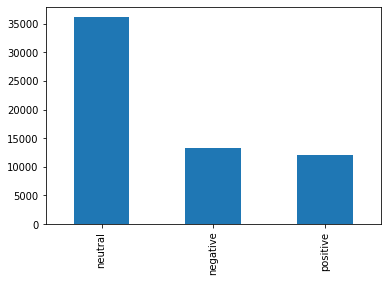

In [253]:
import matplotlib.pyplot as plt
%matplotlib inline
ax = new_df.sentiment.map(id2label).value_counts().plot.bar()

In [263]:
import torch
import scipy as sp
def f(x):
    tv = torch.tensor([tokenizer.encode(v, padding='max_length', max_length=128,truncation=True) for v in x])
    attention_mask = (tv!=0).type(torch.int64)
    outputs = model(tv,attention_mask=attention_mask)[0].detach().cpu().numpy()
    scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T
    val = sp.special.logit(scores)
    return val

In [269]:
explainer = shap.Explainer(f,tokenizer,output_names=labels)

### Negative example: "My iPad auto correct sucks"
- Majority of tokens associated with negative class

In [456]:
# My iPad auto correct sucks
shap_values_negative = explainer(pd.Series(negative_obs.loc[28603].cleaned_content))
shap.plots.text(shap_values_negative)



Partition explainer: 2it [00:12,  6.06s/it]               


,,My,iPad,auto,correct,sucks,
negative,0.0,-0.006,-0.009,0.008,0.012,0.004,-0.0
neutral,0.0,0.013,0.005,0.004,-0.004,0.003,0.0
positive,-0.0,-0.006,0.005,-0.012,-0.009,-0.008,-0.0


### Positive example: "Loves my iPad :D"
- Majority of tokens associated with positive class

In [462]:
# Loves my ipad :D
shap_values_positive = explainer(pd.Series(positive_obs.loc[22073].cleaned_content))
shap.plots.text(shap_values_positive)



Partition explainer: 2it [00:15,  7.98s/it]               


,,L,oves,my,ip,ad,:,D,
negative,0.0,0.005,-0.004,-0.012,-0.007,0.006,-0.001,-0.0,0.0
neutral,0.0,-0.013,0.001,0.008,0.002,-0.0,-0.005,-0.012,-0.0
positive,-0.0,0.008,0.004,0.005,0.005,-0.006,0.007,0.013,0.0
